# TeleCommunication Churn Model Using MLPs

This note book is trying to develope Neural Network classifier for Telcom churn data set. This models are very important for service related companies to predict customers are more likely to stop using their services. This would help them better direct the rewards and promotions according to their marketing strategy. I will provide 3 models trained over original data (imbalanced towards non-churn), balanced data, imblanaced (towards churn ones).


## 1.  Import Packages and Loading Original Data




In [0]:
import tensorflow as tf

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#imports
import numpy as np
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense
from keras import optimizers
import matplotlib 
matplotlib.use('agg')
import matplotlib.pyplot as plt                        
%matplotlib inline
import os
import datetime
import time
from PIL import ImageFile
from sklearn import preprocessing
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings("ignore")
import pylab as pl
import pandas as pd 
import seaborn as sns
from sklearn.utils import shuffle


Using TensorFlow backend.


In [0]:
# you amy change csv file path
data = pd.read_csv("/content/gdrive/My Drive/churn model/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2.   Data Processing



Data types viewing

In [0]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Replace binary categorial data with 0 or 1

In [0]:
#data Manipulation


#Dropping null values from total charges column
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')
data.dropna(inplace = True)
#Dropping customerID
data.drop(labels=['customerID'],axis=1,inplace=True)
data.reset_index()
#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']

data[replace_cols]  = data[replace_cols].replace({'No internet service' : 'No'})

columns_to_convert = ['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity','OnlineBackup','DeviceProtection',
                      'TechSupport','StreamingTV','StreamingMovies','PaperlessBilling', 'Churn']
data[columns_to_convert]  = data[columns_to_convert].replace({'No' : 0,'Yes':1})
data['MultipleLines'] = [1 if each == "Yes" else 0 if each == "No" else -1 for each in data['MultipleLines']]
data['gender']= data['gender'].replace({'Female':1, 'Male':0})
data.head()



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,-1,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,0,-1,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,1,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


One hot encoding for multi-lables categorial data

In [0]:
data = pd.get_dummies(data=data)
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,-1,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,45,0,-1,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [0]:
data.corr()['Churn'].sort_values()

tenure                                    -0.354049
Contract_Two year                         -0.301552
InternetService_No                        -0.227578
TotalCharges                              -0.199484
Contract_One year                         -0.178225
OnlineSecurity                            -0.171270
TechSupport                               -0.164716
Dependents                                -0.163128
Partner                                   -0.149982
PaymentMethod_Credit card (automatic)     -0.134687
InternetService_DSL                       -0.124141
PaymentMethod_Bank transfer (automatic)   -0.118136
PaymentMethod_Mailed check                -0.090773
OnlineBackup                              -0.082307
DeviceProtection                          -0.066193
gender                                     0.008545
PhoneService                               0.011691
MultipleLines                              0.036148
StreamingMovies                            0.060860
StreamingTV 

## 3.   Training and Testing Data Sets




Create train and testing  data sets

In [0]:
#assign Class_att column as y attribute
y_original = data.Churn.values

#drop Class_att column, remain only numerical columns
new_data = data.drop(["Churn"],axis=1)
x_original=new_data.values

In [0]:
x_original=preprocessing.StandardScaler().fit_transform(x_original)


Create balance data sets. In my opnion, it is the best one to better evaluate classifiers performance. 

In [0]:
#create balanced test data set
index=y_original==0
x0=x_original[index]
y0=y_original[index]
print(len(x_original))
index=np.invert(index)
x1=x_original[index]
y1=y_original[index]
x1,x1_test,y1,y1_test=train_test_split(x1, y1, test_size=500, random_state=42)
x0,x0_test,y0,y0_test=train_test_split(x0, y0, test_size=500, random_state=42)
x_original=np.concatenate((x0,x1))
y_original=np.concatenate((y0,y1))
X_test=np.concatenate((x0_test,x1_test))
y_test=np.concatenate((y0_test,y1_test))
x_original,y_original=shuffle(x_original,y_original,random_state=113)
print(len(x_original))
print(len(x_test))

7032
6032
1000


In [0]:
print(x_original.shape)
print(y_original.shape)
print(x_test.shape)
print(y_test.shape)

(6032, 26)
(6032,)
(1000, 26)
(1000,)


## 4. TSNE Visualization

Data visualization using dimentionality reduction to better view data

In [0]:
from sklearn import manifold

In [0]:
se = manifold.SpectralEmbedding(n_components=2, n_neighbors=10)
X_se = se.fit_transform(x_original)

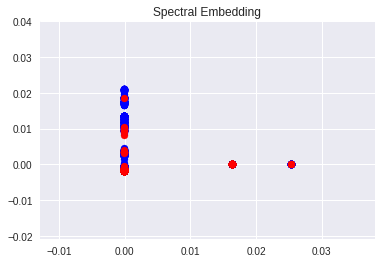

In [0]:
X_n=X_se
index=y_original==0
plt.scatter(X_n[index][:, 0], X_n[index][:, 1], c='b', cmap=plt.cm.Spectral)
index=np.invert(index)
plt.scatter(X_n[index][:, 0], X_n[index][:, 1], c='r', cmap=plt.cm.Spectral)
plt.title("Spectral Embedding")
plt.show()

Spectral embedding shows that there is much overlapping between churn and no churn labels. Although non churn are almost 3x the churn ones. This means that there is much feature similariy between churn and no churn customers

In [0]:
tsne = manifold.TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(x_original)

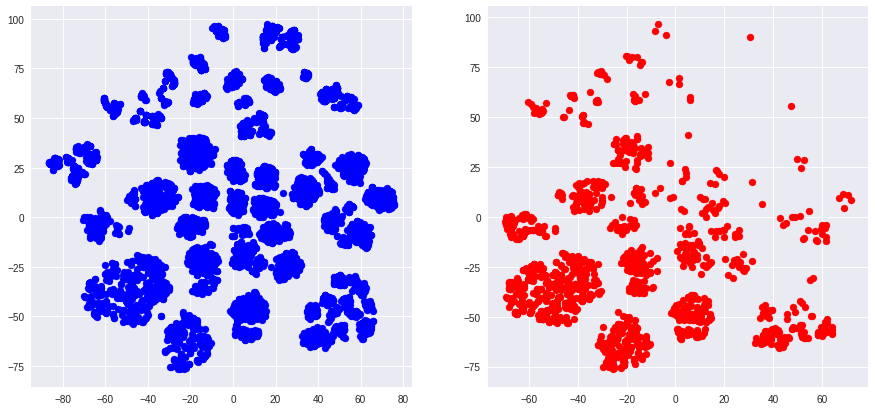

In [0]:
X_n=X_tsne
f, axarr = plt.subplots(1,2,figsize=(15,7))
#axarr[0,0].scatter()
#axarr[0,0].grid(False)
index=y_original==0
axarr[0].scatter(X_n[index][:, 0], X_n[index][:, 1], c='b', cmap=plt.cm.Spectral)
index=np.invert(index)
axarr[1].scatter(X_n[index][:, 0], X_n[index][:, 1], c='r', cmap=plt.cm.Spectral)

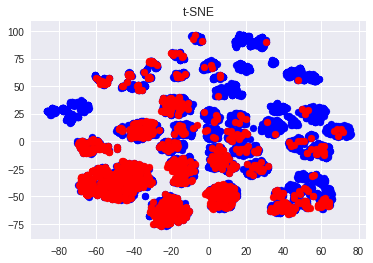

In [0]:
X_n=X_tsne
index=y_original==0
plt.scatter(X_n[index][:, 0], X_n[index][:, 1], c='b', cmap=plt.cm.Spectral)
index=np.invert(index)
plt.scatter(X_n[index][:, 0], X_n[index][:, 1], c='r', cmap=plt.cm.Spectral)
plt.title("t-SNE")
plt.show()

## 5. Model Parameters

MLP parameters

In [0]:
#model parameters
input_size=x_original.shape[1]
output_classes=2
hidden_layers=3
hidden_layers_size=[200,200,50]
activation=['tanh','tanh','tanh']
dropout=[0.0,0.0,0.0]
retrain=False
learning_rate=0.00001
# enter model path and file name where you want to load or save your new model
model_path="/content/gdrive/My Drive/churn model/churn_model_tanh_original.h5"

## 6.  MLP Functions

### 6.1 Create MLP

In [0]:
def create_MLP(input_s,output_s,hidden_layers,hidden_size,activation,dropout,learning_rate):
    ml=[]
    layers=[input_s]+hidden_size+[output_s]
    dropout=[0.0]+dropout+[0.0]
    activation=['']+activation+['']
    ml.append(Dense(layers[1],input_shape=[input_s],activation=eval('tf.nn.'+activation[1])))
    for i in range(2,len(layers)-1):
        #print('tf.nn.'+activation[i])
        ml.append(Dense(layers[i],activation=eval('tf.nn.'+activation[i])))
    ml.append(Dense(layers[-1],activation=tf.nn.softmax))
    print(ml)
    model=tf.keras.models.Sequential(ml)
    adam= optimizers.Adam(lr=learning_rate)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

### 6.2 Testing Model

In [0]:
def test_model(model,features,labels):
    test_loss,test_accuracy=model.evaluate(features,labels)
    return test_accuracy,test_loss

### 6.3 Testing  Model and Priniting Classification Report, Accuracy Score, and Confusion Matrix

In [0]:
def test_report_model(model,features,labels):
    test_loss,test_accuracy=model.evaluate(features,labels)
    prob=model.predict(features)
    print(prob.shape)
    print(prob[0])
    predictions=np.argmax(prob,axis=1)
    print(predictions.shape)
    print(classification_report(labels, predictions,digits=5))
    print ("Accuracy Score: ",accuracy_score(labels,predictions))
    conf_matrix=confusion_matrix(labels,predictions)
    #print ("Confusion Matrix: ",conf_matrix)
    import seaborn as sns
    f, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(conf_matrix, annot = True, linewidths = 0.5, color = "red", fmt = ".0f", ax=ax)
    plt.xlabel("y_predicted")
    plt.ylabel("y_true")
    plt.title("Confusion Matrix")
    plt.show()
    return test_accuracy

### 6.4 Training And Saving Model

In [0]:
def train_model(model,epochs,features_train,labels_train,features_valid,labels_valid,valid_acc_max,model_path_name):
    for i in range(epochs):
      history=model.fit(features_train,labels_train,batch_size=len(features_train),epochs=1)
      _,valid_acc=model.evaluate(features_valid,labels_valid)
      #valid_acc=history['acc'][0]
      if valid_acc>valid_acc_max:
        print(f"*************New Model Saved with correct predictions of:{valid_acc:.5f}***************")
        model.save(model_path_name)
        valid_acc_max= valid_acc
    return model,valid_acc_max

## 7. Model Creation 

Create Model, either retrain saved model or create new one.

In [0]:
# Model instainstiation
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if(retrain):
    model = tf.keras.models.load_model(model_path)
    import tensorflow.keras.backend as K
    # To get learning rate
    print(K.get_value(model.optimizer.lr))
    # To set learning rate
    K.set_value(model.optimizer.lr, learning_rate)
    print(K.get_value(model.optimizer.lr))
    
else:
    model=create_MLP(input_size,output_classes,hidden_layers,hidden_layers_size,activation,dropout,learning_rate)

[<tensorflow.python.keras.layers.core.Dense object at 0x7fe59e7ec2b0>, <tensorflow.python.keras.layers.core.Dense object at 0x7fe59cfc6d30>, <tensorflow.python.keras.layers.core.Dense object at 0x7fe592528470>, <tensorflow.python.keras.layers.core.Dense object at 0x7fe592528710>]


In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 200)               5400      
_________________________________________________________________
dense_9 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_10 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 102       
Total params: 55,752
Trainable params: 55,752
Non-trainable params: 0
_________________________________________________________________
None


## 8. Training Model-- Original Data

In [0]:
# test model intially over validation set
valid_acc_max,valid_loss,=test_model(model,x_test,y_test)
print(valid_acc_max,valid_loss)

1000/1000 [==============================] - 0s 121us/sample - loss: 0.7586 - acc: 0.4480
0.448 0.7585938339233398


In [0]:
#train model
model,valid_acc_max = train_model(model,500, x_original, y_original, X_test, y_test, valid_acc_max,model_path) 
print(valid_acc_max)

1000/1000 [==============================] - 0s 74us/sample - loss: 1.5853 - acc: 0.6530
0.756


## 9. Testing Best Model

1000/1000 [==============================] - 0s 145us/sample - loss: 0.5166 - acc: 0.7560
(1000, 2)
[0.74166805 0.258332  ]
(1000,)
              precision    recall  f1-score   support

           0    0.80332   0.67800   0.73536       500
           1    0.72145   0.83400   0.77365       500

   micro avg    0.75600   0.75600   0.75600      1000
   macro avg    0.76239   0.75600   0.75451      1000
weighted avg    0.76239   0.75600   0.75451      1000

Accuracy Score:  0.756


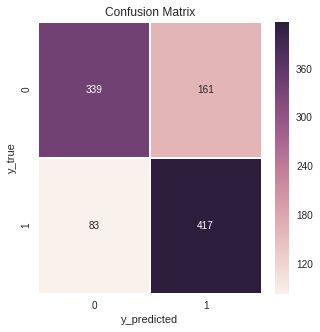

0.756

In [0]:
model=tf.keras.models.load_model(model_path)
test_report_model(model,X_test,y_test)

## 10. Original Data Conclusion
The model accuracy is 75.6%.  It is also skewed model because of  data imbalance. In order to resolve this, I will do data augmentation. 


## 11. Data Augmentation: Create Balanced Train Data Set 

In this section, a new train data set will be created with balanced number of churn and no-churn users using data augmentation. 

In [0]:
from sklearn.utils import shuffle
x_balanced=x_original
y_balanced=y_original
print(len(x_original))
print(np.sum(y_original==1))
print(np.sum(y_original==0))
print(np.sum(y_original==0)//np.sum(y_original==1))
print(np.sum(y_original==0)%np.sum(y_original==1))
x0=x_original[y_original==0]
x1=x_original[y_original==1]
y0=y_original[y_original==0]
y1=y_original[y_original==1]
q=len(x0)//len(x1)-1
r=len(x0)%len(x1)
for i in range(0,q):
  x_balanced=np.concatenate((x_balanced,x1))
  y_balanced=np.concatenate((y_balanced,y1))
_,dumx,_,dumy=train_test_split(x1,y1,test_size=r,random_state=42)
x_balanced=np.concatenate((x_balanced,dumx))
y_balanced=np.concatenate((y_balanced,dumy))
print(np.sum(y_balanced==1))
print(np.sum(y_balanced==0))
x_balanced,y_balanced=shuffle(x_balanced,y_balanced, random_state=113)

6032
1369
4663
3
556
4663
4663


## 12. TSNE Visualization

In [0]:
se = manifold.SpectralEmbedding(n_components=2, n_neighbors=10)
X_se = se.fit_transform(x_balanced)

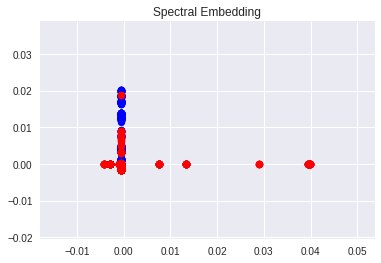

In [0]:
X_n=X_se
index=y_balanced==0
plt.scatter(X_n[index][:, 0], X_n[index][:, 1], c='b', cmap=plt.cm.Spectral)
index=np.invert(index)
plt.scatter(X_n[index][:, 0], X_n[index][:, 1], c='r', cmap=plt.cm.Spectral)
plt.title("Spectral Embedding")
plt.show()

In [0]:
tsne = manifold.TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(x_balanced)

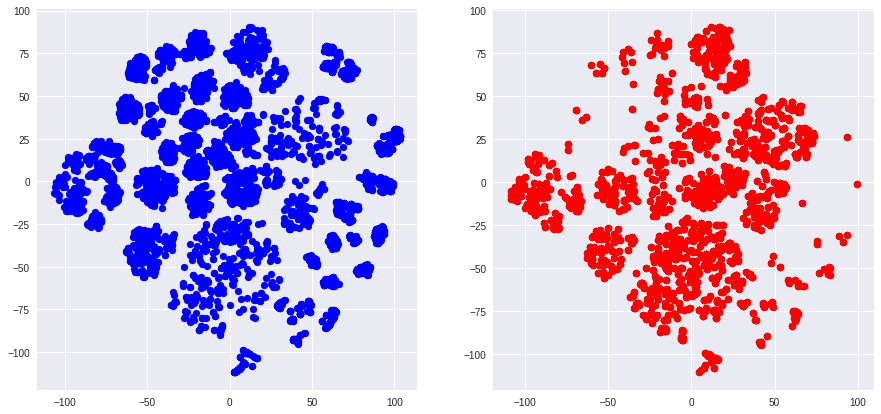

In [0]:
X_n=X_tsne
f, axarr = plt.subplots(1,2,figsize=(15,7))
#axarr[0,0].scatter()
#axarr[0,0].grid(False)
index=y_balanced==0
axarr[0].scatter(X_n[index][:, 0], X_n[index][:, 1], c='b', cmap=plt.cm.Spectral)
index=np.invert(index)
axarr[1].scatter(X_n[index][:, 0], X_n[index][:, 1], c='r', cmap=plt.cm.Spectral)

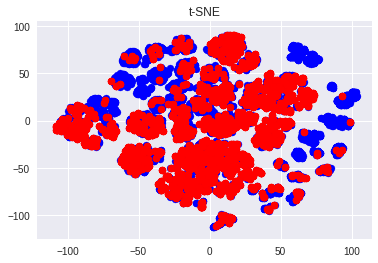

In [0]:
X_n=X_tsne
index=y_balanced==0
plt.scatter(X_n[index][:, 0], X_n[index][:, 1], c='b', cmap=plt.cm.Spectral)
index=np.invert(index)
plt.scatter(X_n[index][:, 0], X_n[index][:, 1], c='r', cmap=plt.cm.Spectral)
plt.title("t-SNE")
plt.show()

## 13. Balanced Data Model Train and Testing

In [0]:
#model parameters
input_size=x_balanced.shape[1]
output_classes=2
hidden_layers=3
hidden_layers_size=[200,200,50]
activation=['tanh','tanh','tanh']
dropout=[0.0,0.0,0.0]
retrain=False
learning_rate=0.00001
# enter model path and file name where you want to load or save your new model
model_path=f"/content/gdrive/My Drive/churn model/churn_model_tanh_balanced.h5"

In [0]:
# Model instainstiation
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if(retrain):
    model = tf.keras.models.load_model(model_path)
    import tensorflow.keras.backend as K
    # To get learning rate
    print(K.get_value(model.optimizer.lr))
    # To set learning rate
    K.set_value(model.optimizer.lr, learning_rate)
    print(K.get_value(model.optimizer.lr))
    
else:
    model=create_MLP(input_size,output_classes,hidden_layers,hidden_layers_size,activation,dropout,learning_rate)

[<tensorflow.python.keras.layers.core.Dense object at 0x7fe57fc24080>, <tensorflow.python.keras.layers.core.Dense object at 0x7fe57fc47080>, <tensorflow.python.keras.layers.core.Dense object at 0x7fe57fc47fd0>, <tensorflow.python.keras.layers.core.Dense object at 0x7fe57fbd9550>]


In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               5400      
_________________________________________________________________
dense_17 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_18 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 102       
Total params: 55,752
Trainable params: 55,752
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# test model intially over validation set
valid_acc_max,valid_loss,=test_model(model,X_test,y_test)
print(valid_acc_max,valid_loss)

1000/1000 [==============================] - 0s 165us/sample - loss: 0.7445 - acc: 0.5380
0.538 0.7445233106613159


In [0]:
#train model
model,valid_acc_max = train_model(model,500, x_balanced, y_balanced, X_test, y_test, valid_acc_max,model_path) 
print(valid_acc_max)

1000/1000 [==============================] - 0s 70us/sample - loss: 2.1713 - acc: 0.6710
0.756


1000/1000 [==============================] - 0s 231us/sample - loss: 0.5008 - acc: 0.7560
(1000, 2)
[0.85439795 0.14560205]
(1000,)
              precision    recall  f1-score   support

           0    0.77004   0.73000   0.74949       500
           1    0.74335   0.78200   0.76218       500

   micro avg    0.75600   0.75600   0.75600      1000
   macro avg    0.75669   0.75600   0.75583      1000
weighted avg    0.75669   0.75600   0.75583      1000

Accuracy Score:  0.756


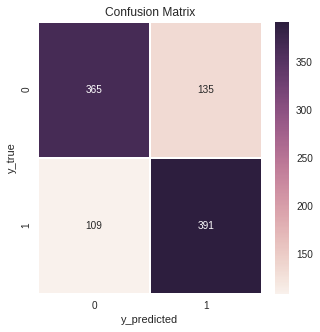

0.756

In [0]:
model=tf.keras.models.load_model(model_path)
test_report_model(model,X_test,y_test)

## 14. Balanced Data Conclusion
Balanced data model out performes original data model in terms of balance between accuracy and precision. Moreover, it is more balanced between churn and non churn customers.

## 15. Skewed Model Towards Churn Customers
In this section, imbalanced train data set is created with more churn customers

In [0]:
from sklearn.utils import shuffle
x_imbalanced=x_balanced
y_imbalanced=y_balanced
x0=x_balanced[y_balanced==0]
x1=x_balanced[y_balanced==1]
y0=y_balanced[y_balanced==0]
y1=y_balanced[y_balanced==1]
for i in range(0,5):
  x_imbalanced=np.concatenate((x_imbalanced,x1))
  y_imbalanced=np.concatenate((y_imbalanced,y1))
print(np.sum(y_imbalanced==1))
print(np.sum(y_imbalanced==0))
x_imbalanced,y_imbalanced=shuffle(x_imbalanced,y_imbalanced, random_state=113)

27978
4663


## 16. TSNE Visualization

In [0]:
se = manifold.SpectralEmbedding(n_components=2, n_neighbors=10)
X_se = se.fit_transform(x_imbalanced)

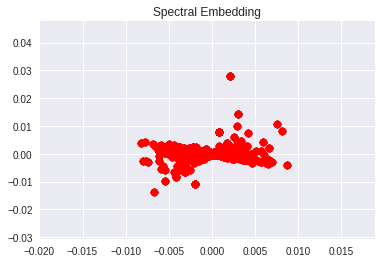

In [0]:
X_n=X_se
index=y_imbalanced==0
plt.scatter(X_n[index][:, 0], X_n[index][:, 1], c='b', cmap=plt.cm.Spectral)
index=np.invert(index)
plt.scatter(X_n[index][:, 0], X_n[index][:, 1], c='r', cmap=plt.cm.Spectral)
plt.title("Spectral Embedding")
plt.show()

In [0]:
tsne = manifold.TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(x_imbalanced)

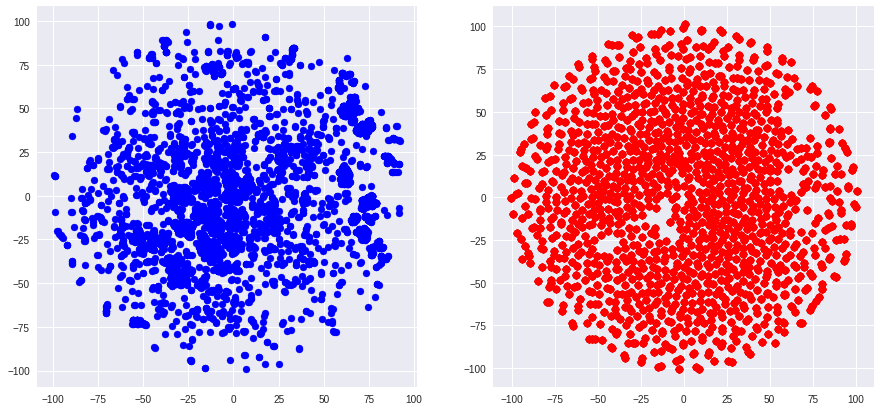

In [0]:
X_n=X_tsne
f, axarr = plt.subplots(1,2,figsize=(15,7))
#axarr[0,0].scatter()
#axarr[0,0].grid(False)
index=y_imbalanced==0
axarr[0].scatter(X_n[index][:, 0], X_n[index][:, 1], c='b', cmap=plt.cm.Spectral)
index=np.invert(index)
axarr[1].scatter(X_n[index][:, 0], X_n[index][:, 1], c='r', cmap=plt.cm.Spectral)

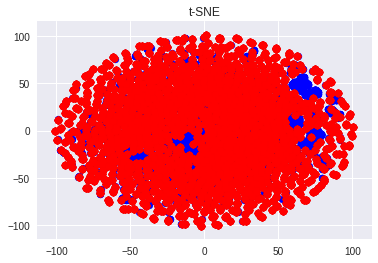

In [0]:
X_n=X_tsne
index=y_imbalanced==0
plt.scatter(X_n[index][:, 0], X_n[index][:, 1], c='b', cmap=plt.cm.Spectral)
index=np.invert(index)
plt.scatter(X_n[index][:, 0], X_n[index][:, 1], c='r', cmap=plt.cm.Spectral)
plt.title("t-SNE")
plt.show()

##17. Model Creation, Train, and Testing

In [0]:
#model parameters
input_size=x_imbalanced.shape[1]
output_classes=2
hidden_layers=3
hidden_layers_size=[200,200,50]
activation=['tanh','tanh','tanh']
dropout=[0.0,0.0,0.0]
retrain=False
learning_rate=0.001
# enter model path and file name where you want to load or save your new model
model_path=f"/content/gdrive/My Drive/churn model/churn_model_tanh_imbalanced.h5"

In [0]:
# Model instainstiation
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if(retrain):
    model = tf.keras.models.load_model(model_path)
    import tensorflow.keras.backend as K
    # To get learning rate
    print(K.get_value(model.optimizer.lr))
    # To set learning rate
    K.set_value(model.optimizer.lr, learning_rate)
    print(K.get_value(model.optimizer.lr))
    
else:
    model=create_MLP(input_size,output_classes,hidden_layers,hidden_layers_size,activation,dropout,learning_rate)

[<tensorflow.python.keras.layers.core.Dense object at 0x7fe590b571d0>, <tensorflow.python.keras.layers.core.Dense object at 0x7fe590b57c88>, <tensorflow.python.keras.layers.core.Dense object at 0x7fe57eef9160>, <tensorflow.python.keras.layers.core.Dense object at 0x7fe57fc5d828>]


In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 200)               5400      
_________________________________________________________________
dense_21 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_22 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 102       
Total params: 55,752
Trainable params: 55,752
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# test model intially over validation set
valid_acc_max,valid_loss,=test_model(model,X_test,y_test)
print(valid_acc_max,valid_loss)

1000/1000 [==============================] - 0s 205us/sample - loss: 0.6400 - acc: 0.6440
0.644 0.6399922542572022


In [0]:
#train model
model,valid_acc_max = train_model(model,500, x_imbalanced, y_imbalanced, X_test, y_test, valid_acc_max,model_path) 
print(valid_acc_max)

1000/1000 [==============================] - 0s 81us/sample - loss: 2.0462 - acc: 0.6610
0.73


1000/1000 [==============================] - 0s 253us/sample - loss: 0.5475 - acc: 0.7300
(1000, 2)
[0.80083925 0.19916071]
(1000,)
              precision    recall  f1-score   support

           0    0.82486   0.58400   0.68384       500
           1    0.67802   0.87600   0.76440       500

   micro avg    0.73000   0.73000   0.73000      1000
   macro avg    0.75144   0.73000   0.72412      1000
weighted avg    0.75144   0.73000   0.72412      1000

Accuracy Score:  0.73


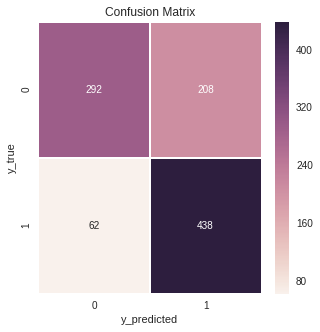

0.73

In [0]:
model=tf.keras.models.load_model(model_path)
test_report_model(model,X_test,y_test)

##18. Conclusion

In this Model, a MLP classifier is developed to achieve churn model classification based on data from telecom operator.

The original data set is imbalanced with more non churn customers.  A balanced test data set is created to test developed classifiers. 

Three train data sets used to train 3 MLP classifiers. The first one is the original imbalanced one, the second was balanced data set made by data augmentation, and the thid one is imbalanced data set with more churn customers made by dat augmentation as well. 

The three models almost achieve close accuracy scores on test data set. However, the first model is skewed in terms of precision and recall. The second model is the best one in terms of balance between precision and recall. 

The third model is developed in case of the company pays much more weight to detect churn clients even on the expense mis predicting non-churn clients. This might help companies with much higher contract values to predict churn clients and try to keep them in the company.